In [1]:
# Import of libraries
import random
import imageio
import numpy as np
from argparse import ArgumentParser

from tqdm.auto import tqdm
import matplotlib.pyplot as plt

import einops
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader

from torchvision.transforms import Compose, ToTensor, Lambda
from torchvision.datasets.mnist import MNIST, FashionMNIST

# Setting reproducibility
SEED = 0
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# Definitions
STORE_PATH_MNIST = f"ddpm_model_mnist.pt"
STORE_PATH_FASHION = f"ddpm_model_fashion.pt"

In [2]:
no_train = False
fashion = False
batch_size = 128
n_epochs = 20
lr = 0.001
store_path = "ddpm_fashion.pt" if fashion else "ddpm_mnist.pt"

In [3]:
def show_images(images, title=""):
    """Shows the provided images as sub-pictures in a square"""

    # Converting images to CPU numpy arrays
    if type(images) is torch.Tensor:
        images = images.detach().cpu().numpy()

    # Defining number of rows and columns
    fig = plt.figure(figsize=(8, 8))
    rows = int(len(images) ** (1 / 2))
    cols = round(len(images) / rows)

    # Populating figure with sub-plots
    idx = 0
    for r in range(rows):
        for c in range(cols):
            fig.add_subplot(rows, cols, idx + 1)

            if idx < len(images):
                plt.imshow(images[idx][0], cmap="gray")
                idx += 1
    fig.suptitle(title, fontsize=30)

    # Showing the figure
    plt.show()

In [4]:
# Shows a batch of images
def show_batch(loader,batch_index=0):
    for i, batch in enumerate(loader):
        if i == batch_index:
            images, _ = batch  # 你也可以不解包，视你的 dataset 而定
            show_images(images, f"Images in batch {batch_index}")
            break

In [5]:
# Loading the data (converting each image into a tensor and normalizing between [-1, 1])
transform = Compose([
    ToTensor(),
    Lambda(lambda x: (x - 0.5) * 2)]
)
ds_fn = FashionMNIST if fashion else MNIST
dataset = ds_fn("../../assets", download=False, train=True, transform=transform)
loader = DataLoader(dataset, batch_size, shuffle=True)

In [6]:
# show_batch(loader,3)

In [7]:
# Getting device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}\t" + (f"{torch.cuda.get_device_name(0)}" if torch.cuda.is_available() else "CPU"))

Using device: cuda	NVIDIA GeForce RTX 4060 Laptop GPU


In [8]:
# DDPM class
class MyDDPM(nn.Module):
    def __init__(self, network, n_steps=200, min_beta=10 ** -4, max_beta=0.02, device=None, image_chw=(1, 28, 28)):
        super(MyDDPM, self).__init__()
        self.n_steps = n_steps
        self.device = device
        self.image_chw = image_chw
        self.network = network.to(device)
        self.betas = torch.linspace(min_beta, max_beta, n_steps).to(
            device)  # Number of steps is typically in the order of thousands
        self.alphas = 1 - self.betas
        self.alpha_bars = torch.tensor([torch.prod(self.alphas[:i + 1]) for i in range(len(self.alphas))]).to(device)

    def forward(self, x0, t, eta=None):
        # Make input image more noisy (we can directly skip to the desired step)
        n, c, h, w = x0.shape
        a_bar = self.alpha_bars[t]

        if eta is None:
            eta = torch.randn(n, c, h, w).to(self.device)

        noisy = a_bar.sqrt().reshape(n, 1, 1, 1) * x0 + (1 - a_bar).sqrt().reshape(n, 1, 1, 1) * eta
        return noisy

    def backward(self, x, t):
        # Run each image through the network for each timestep t in the vector t.
        # The network returns its estimation of the noise that was added.
        return self.network(x, t)

In [9]:
def show_forward(ddpm, loader, device):
    # Showing the forward process
    for batch in loader:
        imgs = batch[0]

        show_images(imgs, "Original images")

        for percent in [0.25, 0.5, 0.75, 1]:
            show_images(
                ddpm(imgs.to(device),
                     [int(percent * ddpm.n_steps) - 1 for _ in range(len(imgs))]),
                f"DDPM Noisy images {int(percent * 100)}%"
            )
        break

In [10]:
def generate_new_images(ddpm, n_samples=16, device=None, frames_per_gif=100, gif_name="sampling.gif", c=1, h=28, w=28):
    """Given a DDPM model, a number of samples to be generated and a device, returns some newly generated samples"""
    frame_idxs = np.linspace(0, ddpm.n_steps, frames_per_gif).astype(np.uint)
    frames = []

    with torch.no_grad():
        if device is None:
            device = ddpm.device

        # Starting from random noise
        x = torch.randn(n_samples, c, h, w).to(device)

        for idx, t in enumerate(list(range(ddpm.n_steps))[::-1]):
            # Estimating noise to be removed
            time_tensor = (torch.ones(n_samples, 1) * t).to(device).long()
            eta_theta = ddpm.backward(x, time_tensor)

            alpha_t = ddpm.alphas[t]
            alpha_t_bar = ddpm.alpha_bars[t]

            # Partially denoising the image
            x = (1 / alpha_t.sqrt()) * (x - (1 - alpha_t) / (1 - alpha_t_bar).sqrt() * eta_theta)

            if t > 0:
                z = torch.randn(n_samples, c, h, w).to(device)

                # Option 1: sigma_t squared = beta_t
                beta_t = ddpm.betas[t]
                sigma_t = beta_t.sqrt()

                # Option 2: sigma_t squared = beta_tilda_t
                # prev_alpha_t_bar = ddpm.alpha_bars[t-1] if t > 0 else ddpm.alphas[0]
                # beta_tilda_t = ((1 - prev_alpha_t_bar)/(1 - alpha_t_bar)) * beta_t
                # sigma_t = beta_tilda_t.sqrt()

                # Adding some more noise like in Langevin Dynamics fashion
                x = x + sigma_t * z

            # Adding frames to the GIF
            if idx in frame_idxs or t == 0:
                # Putting digits in range [0, 255]
                normalized = x.clone()
                for i in range(len(normalized)):
                    normalized[i] -= torch.min(normalized[i])
                    normalized[i] *= 255 / torch.max(normalized[i])

                # Reshaping batch (n, c, h, w) to be a (as much as it gets) square frame
                frame = einops.rearrange(normalized, "(b1 b2) c h w -> (b1 h) (b2 w) c", b1=int(n_samples ** 0.5))
                frame = frame.cpu().numpy().astype(np.uint8)

                # Rendering frame
                frames.append(frame)

    # Storing the gif
    with imageio.get_writer(gif_name, mode="I") as writer:
        for idx, frame in enumerate(frames):
            rgb_frame = np.repeat(frame, 3, axis=2)
            writer.append_data(rgb_frame)

            # Showing the last frame for a longer time
            if idx == len(frames) - 1:
                last_rgb_frame = np.repeat(frames[-1], 3, axis=2)
                for _ in range(frames_per_gif // 3):
                    writer.append_data(last_rgb_frame)
    return x

In [11]:
def sinusoidal_embedding(n, d):
    # Returns the standard positional embedding
    embedding = torch.zeros(n, d)
    wk = torch.tensor([1 / 10_000 ** (2 * j / d) for j in range(d)])
    wk = wk.reshape((1, d))
    t = torch.arange(n).reshape((n, 1))
    embedding[:,::2] = torch.sin(t * wk[:,::2])
    embedding[:,1::2] = torch.cos(t * wk[:,::2])

    return embedding

In [12]:
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=3, padding=1),
            nn.SiLU(),
            nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        )
        self.activation = nn.SiLU()

    def forward(self, x):
        return self.activation(x + self.block(x))


class ResNetForDDPM(nn.Module):
    def __init__(self, n_steps=1000, time_emb_dim=100):
        super().__init__()

        self.time_embed = nn.Embedding(n_steps, time_emb_dim)
        self.time_embed.weight.data = sinusoidal_embedding(n_steps, time_emb_dim)
        self.time_embed.requires_grad_(False)

        self.time_proj = nn.Sequential(
            nn.Linear(time_emb_dim, 28 * 28),
            nn.SiLU()
        )

        self.input_proj = nn.Conv2d(2, 32, kernel_size=3, padding=1)

        self.resblocks = nn.Sequential(
            ResidualBlock(32),
            ResidualBlock(32),
            ResidualBlock(32)
        )

        self.output_proj = nn.Conv2d(32, 1, kernel_size=3, padding=1)

    def forward(self, x, t):
        n = x.size(0)
        t = t.view(-1)
        t_emb = self.time_proj(self.time_embed(t))  # (n, 784)
        t_feat = t_emb.view(n, 1, 28, 28)  # → feature map
        x = torch.cat([x, t_feat], dim=1)  # (n, 2, 28, 28)

        h = self.input_proj(x)
        h = self.resblocks(h)
        out = self.output_proj(h)
        return out

In [13]:
# Defining model
n_steps, min_beta, max_beta = 1000, 10 ** -4, 0.02  # Originally used by the authors

mlp_network = ResNetForDDPM().to(device)
ddpm_res = MyDDPM(network=mlp_network, n_steps=n_steps, min_beta=min_beta, max_beta=max_beta, device=device)

In [14]:
# 测试
x = torch.randn(8, 1, 28, 28).to(device)  # 8 张 28x28 的灰度图
t = torch.randint(0, 200, (8,)).to(device)  # 随机选择时间步
eta_hat = ddpm_res.backward(x, t)  # 预测噪声
print(eta_hat.shape)  # 输出应为 (8, 1, 28, 28)

torch.Size([8, 1, 28, 28])


In [15]:
sum([p.numel() for p in ddpm_res.parameters()])

235569

In [16]:
# Optionally, show the diffusion (forward) process
# show_forward(ddpm_mlp, loader, device)

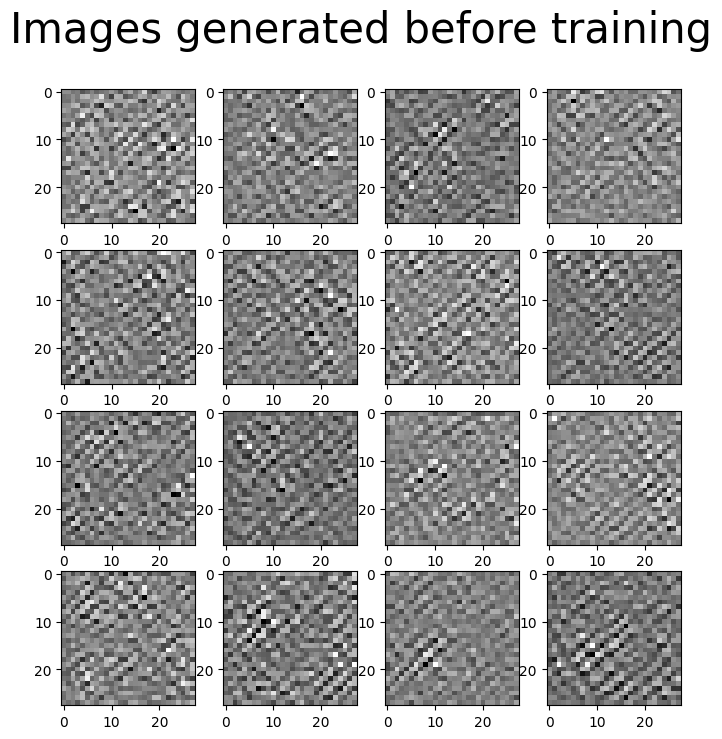

In [17]:
# Optionally, show the denoising (backward) process
generated = generate_new_images(ddpm_res, gif_name="before_training.gif")
show_images(generated, "Images generated before training")

In [18]:
def training_loop(ddpm, loader, n_epochs, optim, device, display=False, store_path="ddpm_model.pt"):
    mse = nn.MSELoss()
    best_loss = float("inf")
    n_steps = ddpm.n_steps

    for epoch in tqdm(range(n_epochs), desc=f"Training progress", colour="#00ff00"):
        epoch_loss = 0.0
        for step, batch in enumerate(tqdm(loader, leave=False, desc=f"Epoch {epoch + 1}/{n_epochs}", colour="#005500")):
            # Loading data
            x0 = batch[0].to(device)
            n = len(x0)

            # Picking some noise for each of the images in the batch, a timestep and the respective alpha_bars
            eta = torch.randn_like(x0).to(device)
            t = torch.randint(0, n_steps, (n,)).to(device)

            # Computing the noisy image based on x0 and the time-step (forward process)
            noisy_imgs = ddpm(x0, t, eta)

            # Getting model estimation of noise based on the images and the time-step
            eta_theta = ddpm.backward(noisy_imgs, t.reshape(n, -1))

            # Optimizing the MSE between the noise plugged and the predicted noise
            loss = mse(eta_theta, eta)
            optim.zero_grad()
            loss.backward()
            optim.step()

            epoch_loss += loss.item() * len(x0) / len(loader.dataset)

        # Display images generated at this epoch
        if display:
            show_images(generate_new_images(ddpm, device=device), f"Images generated at epoch {epoch + 1}")

        log_string = f"Loss at epoch {epoch + 1}: {epoch_loss:.3f}"

        # Storing the model
        if best_loss > epoch_loss:
            best_loss = epoch_loss
            torch.save(ddpm.state_dict(), store_path)
            log_string += " --> Best model ever (stored)"

        print(log_string)

In [19]:
# Training
store_path = "ddpm_mlp_fashion.pt" if fashion else "ddpm_mlp_mnist.pt"
if not no_train:
    training_loop(ddpm_res, loader, n_epochs, optim=Adam(ddpm_res.parameters(), lr), device=device, store_path=store_path)

Training progress:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 1: 0.106 --> Best model ever (stored)


Epoch 2/20:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 2: 0.043 --> Best model ever (stored)


Epoch 3/20:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 3: 0.037 --> Best model ever (stored)


Epoch 4/20:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 4: 0.034 --> Best model ever (stored)


Epoch 5/20:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 5: 0.033 --> Best model ever (stored)


Epoch 6/20:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 6: 0.033 --> Best model ever (stored)


Epoch 7/20:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 7: 0.031 --> Best model ever (stored)


Epoch 8/20:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 8: 0.030 --> Best model ever (stored)


Epoch 9/20:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 9: 0.030


Epoch 10/20:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 10: 0.030 --> Best model ever (stored)


Epoch 11/20:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 11: 0.029 --> Best model ever (stored)


Epoch 12/20:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 12: 0.029 --> Best model ever (stored)


Epoch 13/20:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 13: 0.029 --> Best model ever (stored)


Epoch 14/20:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 14: 0.029


Epoch 15/20:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 15: 0.029


Epoch 16/20:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 16: 0.028 --> Best model ever (stored)


Epoch 17/20:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 17: 0.028


Epoch 18/20:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 18: 0.028


Epoch 19/20:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 19: 0.028


Epoch 20/20:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 20: 0.028 --> Best model ever (stored)


In [20]:
# Loading the trained model
best_model = MyDDPM(mlp_network, n_steps=n_steps, device=device)
best_model.load_state_dict(torch.load(store_path, map_location=device))
best_model.eval()
print("Model loaded")

Model loaded


C:\Users\zhang\AppData\Local\Temp\ipykernel_36372\2601572768.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(store_path, map_locati

Generating new images


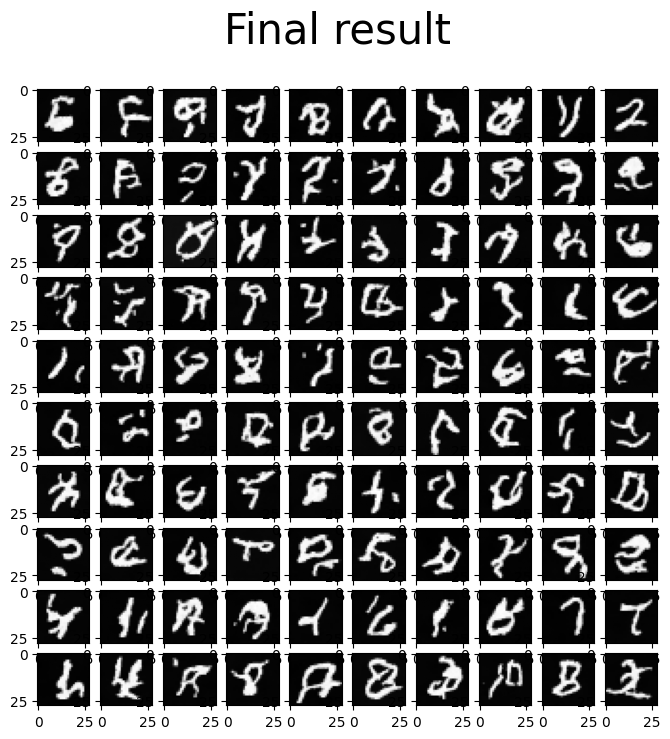

In [21]:
print("Generating new images")
generated = generate_new_images(
        best_model,
        n_samples=100,
        device=device,
        gif_name="fashion.gif" if fashion else "mnist.gif"
    )
show_images(generated, "Final result")